### In this tutorial, we demonstrate how to apply ALLOCATE to temporal single-cell omics data (mouse pancreatic development) for cell alignment.

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
### First, we import the functions required to run the tutorial.
import scanpy as sc
import numpy as np

from src.ALLOCATE import scALLOCATE

from src.ALLOCATE import plot_ALLOCATE_a_distribution
from src.ALLOCATE import plot_ALLOCATE_a_umap
from src.ALLOCATE import plot_ALLOCATE_a_violin

from src.ALLOCATE import get_mapping
from src.ALLOCATE import compute_temporal_growth
from src.ALLOCATE import spearman_scatter_plot

from src.ALLOCATE import aggregate_pi_by_celltype
from src.ALLOCATE import plot_ALLOCATE_transfer_heatmap
from src.ALLOCATE import pi_process
from src.ALLOCATE import compute_mapping_accuracy

### This is the ALLOCATE tutorial for single-cell data.

We next load the mouse pancreas development dataset, which can be downloaded from moscot (https://moscot.readthedocs.io/en/latest/notebooks/tutorials/200_temporal_problem.html).

adata = mt.datasets.pancreas_multiome(rna_only=True, force_download=False)

In this dataset, embryonic pancreas tissues were profiled at embryonic days (E14.5, E15.5, and E16.5) using the 10x Genomics Multiome platform.

In [3]:
adata = sc.read_h5ad('/lustre/home/acct-clswt/clswt-jiaxinchen/ALLOCATE_backup/Data/pancreas.h5ad')

We visualize the dataset, coloring cells by cell type.

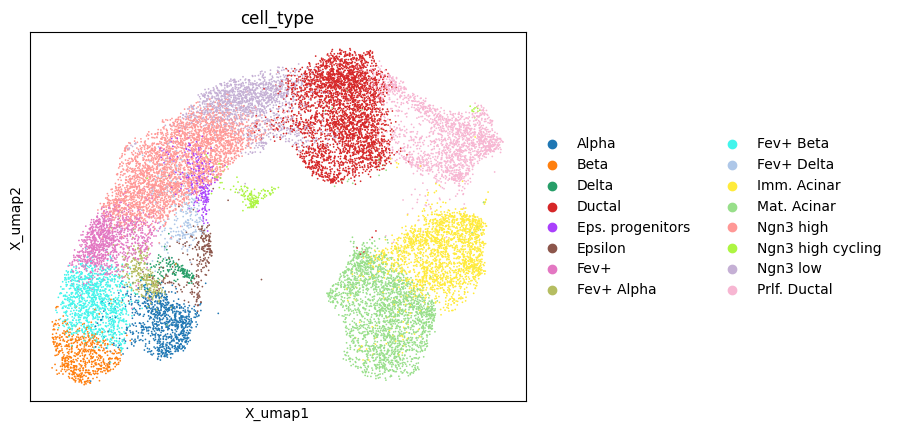

In [4]:
sc.pl.embedding(adata, basis="X_umap", color="cell_type")

### Compute the cost matrix and solve the problem.
As an illustrative example, we map cells at E14.5 to cells at E15.5. The cost matrix in the optimal transport problem is computed based on the Euclidean distance in the latent space defined by obsm['X_pca'].

This step will take approximately five minutes.
The main returned value (a) represents the cell growth potential and (pi) represents the cell transition matrix.

In [5]:
# Run scALLOCATE
a, pi, stats, a_history, pi_history = scALLOCATE(adata, 
       early_tp="E14.5",
       late_tp="E15.5",
       time_key="stage", 
       rep="X_pca",
       epsilon=0.1,
       lambda_val=0.5,
       max_iters=10)


Outer layer 1/10
Outer layer 2/10
Outer layer 3/10
Outer layer 4/10
Outer layer 5/10
Outer layer 6/10
Outer layer 7/10
Outer layer 8/10
Outer layer 9/10
Outer layer 10/10


ALLOCATE calculates the left marginal, and we visualize its distribution.

<Axes: title={'center': 'Marginal Distribution'}, xlabel='log10(a)', ylabel='Cell count'>

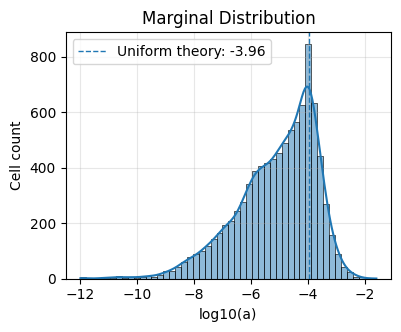

In [6]:
plot_ALLOCATE_a_distribution(
    a,
    title="Marginal Distribution",
    savepath=None,
)

In [7]:
E145 = adata[adata.obs["stage"]=='E14.5',:]
E155 = adata[adata.obs["stage"]=='E15.5',:]

ALLOCATE calculates the left marginal, and we visualize its in UMAP space.

/tmp/ipykernel_3318148/1783668579.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  E145.obs["ot_a"] = a
/lustre/home/acct-clswt/clswt-jiaxinchen/ALLOCATE_backup/src/ALLOCATE/plotting.py:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs[group_mean_key] = adata.obs.groupby(group_key)[a_key].transform("mean")


<Axes: title={'center': 'UMAP colored by mean OT a (cell_type)'}, xlabel='UMAP1', ylabel='UMAP2'>

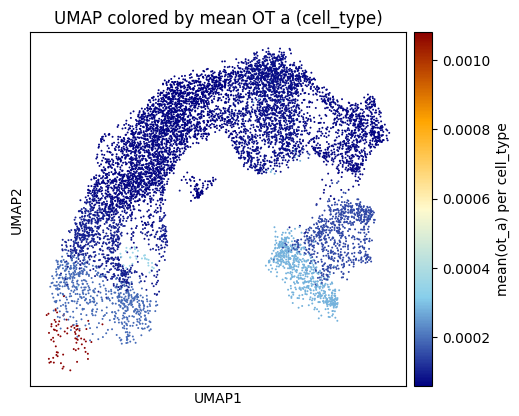

In [8]:
E145.obs["ot_a"] = a
plot_ALLOCATE_a_umap(
    E145,
    a_key="ot_a",
    group_key="cell_type",
    title="UMAP colored by mean OT a (cell_type)",
    savepath=None,
)

Display the growth potential at E14.5 for individual cells and compare it across cell types.

/lustre/home/acct-clswt/clswt-jiaxinchen/ALLOCATE_backup/src/ALLOCATE/plotting.py:373: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = adata.obs.groupby(group_key)[a_key].mean().sort_values(ascending=not descending).index.tolist()


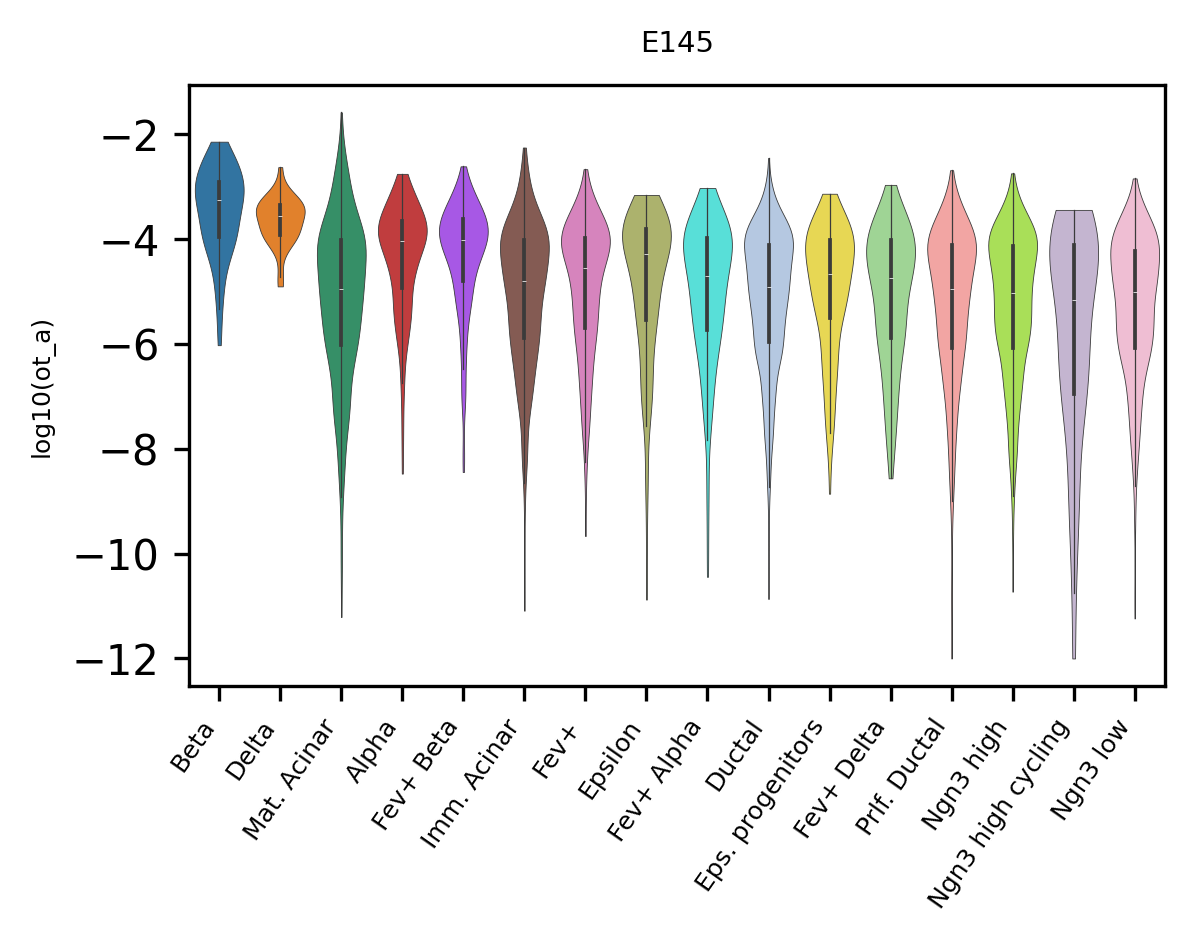

<Axes: title={'center': 'E145'}, ylabel='log10(ot_a)'>

In [9]:
plot_ALLOCATE_a_violin(
    E145,
    a=a,
    group_key="cell_type",
    title="E145",
    savepath=None,
)

We defined and calculated the change in cell abundance between two time points using a proliferation gamma paramater, which quantifies the relative proliferation rate between two biological conditions. 

In [10]:
adapt_a = E145.obs['ot_a']
adapt_a_means = adapt_a.groupby(E145.obs['cell_type']).mean().reset_index(name='a_means')

pi_matrix = pi
t1 = E145
t2 = E155
celltype='cell_type'

parent_mapping, type_transfer = get_mapping(pi_matrix, t1, t2, celltype_col="cell_type")
gamma_df = compute_temporal_growth(
    early_obs=t1.obs,
    late_obs=t2.obs,
    celltype_col="cell_type",
    subtype_parent_map=parent_mapping,
)
gamma_df

/tmp/ipykernel_3318148/1527526630.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adapt_a_means = adapt_a.groupby(E145.obs['cell_type']).mean().reset_index(name='a_means')


,cell_type,gamma
0,Alpha,0.765621
1,Fev+,-0.007801
2,Imm. Acinar,0.511150
3,Eps. progenitors,-0.469286
4,Ngn3 high,-0.366551
5,Ngn3 low,-0.443773
6,Fev+ Beta,1.099774
7,Ductal,-0.325251
8,Fev+ Alpha,-0.250256
9,Mat. Acinar,1.294418


Computed the Spearman correlation between the (gamma) and the learned marginal (a) . 

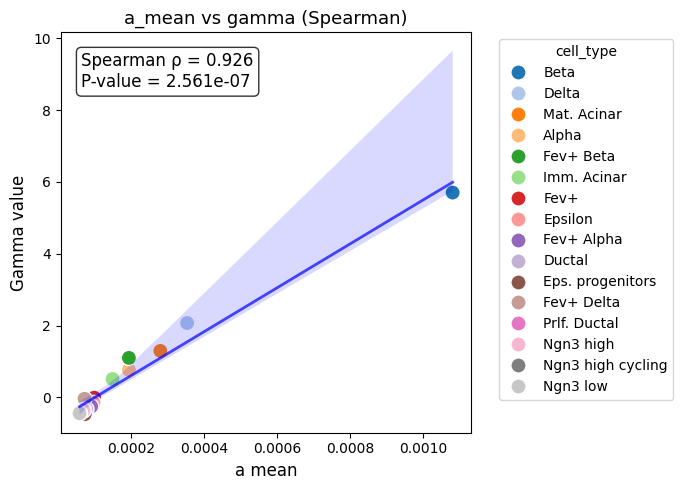

In [11]:
spearman_r, spearman_p, fig = spearman_scatter_plot(
    a_means_df=adapt_a_means,
    gamma_df=gamma_df,
    x_col="a_means",
    y_col="gamma",
    hue_col="cell_type",
    title="a_mean vs gamma (Spearman)",
)

ALLOCATE accurately aligned cells across time points, with the cell-type alignment matrix exhibiting a clear diagonal structure.
The vertical axis of the heatmap represents the previous time point, while the horizontal axis represents the subsequent time point.

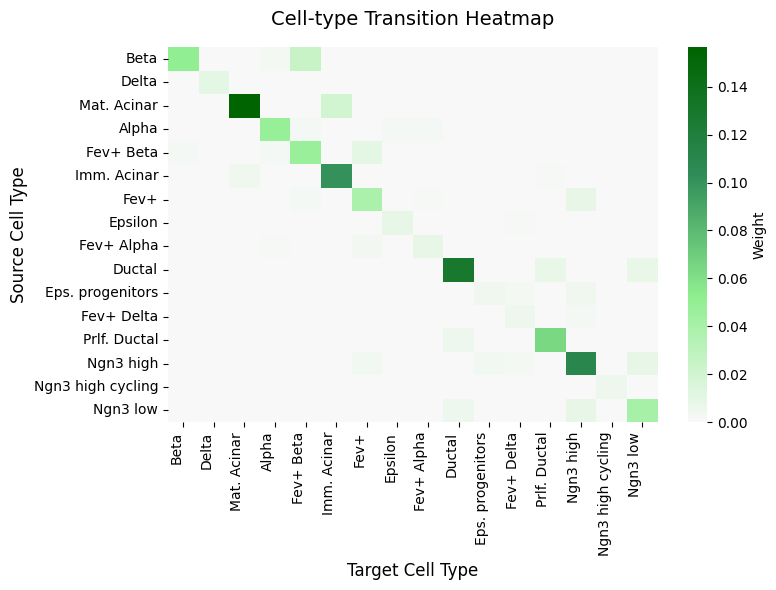

<Axes: title={'center': 'Cell-type Transition Heatmap'}, xlabel='Target Cell Type', ylabel='Source Cell Type'>

In [12]:
transfer_df = aggregate_pi_by_celltype(E145, E155, pi, celltype_key="cell_type")

# The heatmap plot for cell-type alignment matrix.
plot_ALLOCATE_transfer_heatmap(
    transfer_df,
    title="Cell-type Transition Heatmap",
    savepath="adapt_pi_heatmap.pdf",
)

Finally, we calculated the cell-type mapping accuracy across two developmental stage pairs.

In [13]:
E145_155_flow_df = pi_process(E145,E155,pi, key = 'cell_type')
compute_mapping_accuracy(E145_155_flow_df,source_col= "source",target_col= "target",weight_col= "weight")

0.8310570082744301